In [1]:
import numpy as np
import itertools
from sklearn.linear_model import LogisticRegression, Lasso, RidgeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import rpy2.robjects as robjects

import matplotlib.pyplot as plt

np.set_printoptions(precision=3)
np.random.seed(42)

In [2]:
def plot_confusion_matrix(axis, cm, classes, 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    im = axis.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    axis.set(title=title, xlabel='Predicted label', ylabel='True label')
    tick_marks = np.arange(len(classes))
    axis.set_xticks(tick_marks)
    axis.set_xticklabels(classes)
    axis.set_yticks(tick_marks)
    axis.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        axis.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    return im


In [3]:
def load_file(name):
    return np.genfromtxt(name, delimiter=",", skip_header=1)
def load_train_and_test_parts():
    X_train = load_file("data/microarray_train.csv")
    X_test = load_file("data/microarray_test.csv")
    y_train = load_file("data/labels_train.csv")
    y_test = load_file("data/labels_test.csv")
    return X_train, X_test, y_train, y_test

In [4]:
labels = load_file('data/labels_for_microarray_data.csv')
dataset = load_file('data/microarray_data.csv')[:, 1:].T
print(labels.shape, dataset.shape)

(969,) (969, 12179)


In [5]:
X_train, X_test, y_train, y_test = load_train_and_test_parts()
print("Train and test sizes: {} {}".format(X_train.shape, X_test.shape))
print("(1, 0) labels count in train test: {} {}".format((np.count_nonzero(y_train==1), np.count_nonzero(y_train==0)), 
                                                        (np.count_nonzero(y_test==1), np.count_nonzero(y_test==0))))
class_names = np.array(["No event", "Met event"])
standarizer = StandardScaler().fit(X_train)
X_std_train = standarizer.transform(X_train)
X_std_test = standarizer.transform(X_test)

Train and test sizes: (726, 12179) (243, 12179)
(1, 0) labels count in train test: (289, 437) (104, 139)


In [6]:
def read_mlcc_result(numb_clust, train_size):
    robjects.r['load']("./mlcc_results/output{}_8_30_40.RData".format(numb_clust))
    s, m, b = robjects.r['res']
    segmentation = np.asarray(s)
    mBIC = np.asarray(m)
    b.names = robjects.r('0:{}'.format(numb_clust-1))
    bases = dict(zip(b.names, map(list,list(b))))
    dimensionalities = np.empty(numb_clust, dtype=np.int32)
    for i in range(numb_clust):
        dimensionalities[i] = len(bases[str(i)]) // train_size
    return segmentation-1, mBIC, dimensionalities

def apply_mlcc_dim_reduction(X, segmentation, dimensionalities):
    numb_clust = dimensionalities.shape[0]
    X_reduced = np.empty((X.shape[0], 0))
    for i in range(numb_clust):
        cluster = X[:, segmentation == i]
        n_components = dimensionalities[i]
        if cluster.shape[1] < n_components: #TODO - maybe mlcc shouldn't allow it
            print("WARNING! Dimensionality of a cluster was greater than the number of variables. Ignoring this cluster.")
        else:
            X_reduced = np.concatenate((X_reduced, PCA(n_components=n_components).fit_transform(cluster)), axis=1)
    return X_reduced

In [7]:
segmentation, mBIC, dimensionalities = read_mlcc_result(100, 969)

In [8]:
X_mlcc_train = apply_mlcc_dim_reduction(X_train, segmentation, dimensionalities)
X_mlcc_test = apply_mlcc_dim_reduction(X_test, segmentation, dimensionalities)

In [9]:
def fit_clf(clf, train_set, train_labels, test_set, test_labels):
    clf = clf.fit(train_set, train_labels)
    print("Train and test scores: {} {}".format(clf.score(train_set, train_labels), clf.score(test_set, test_labels)))
    plot_clf(clf, train_set, train_labels, test_set, test_labels)
    return clf

def plot_clf(clf, train_set, train_labels, test_set, test_labels):
    test_labels_pred = clf.predict(test_set)
    train_labels_pred = clf.predict(train_set)
    test_cm = confusion_matrix(test_labels, test_labels_pred)
    train_cm = confusion_matrix(train_labels, train_labels_pred)
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True) 
    im = plot_confusion_matrix(ax1, test_cm, classes=class_names, normalize=True, title='Test confusion matrix')
    im = plot_confusion_matrix(ax2, train_cm, classes=class_names, normalize=True, title="Train confusion matrix")
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
    
def fit_models(train_set, train_labels, test_set, test_labels):
    clf_logit = fit_clf(LogisticRegression(solver='liblinear', penalty='l1', C=0.3), train_set, train_labels, test_set, test_labels)
    plt.figure()
    plt.title('Logistics regression coefficients')
    plt.plot(np.arange(clf_logit.coef_.shape[1]), clf_logit.coef_[0])
    plt.show()
    clf_svm = fit_clf(SVC(gamma='scale', C=7), train_set, train_labels, test_set, test_labels)
    clf_tree = fit_clf(DecisionTreeClassifier(max_depth=4, min_samples_leaf=10), train_set, train_labels, test_set, test_labels)
    clf_forest = fit_clf(RandomForestClassifier(max_depth=4, n_estimators=100, min_samples_leaf=10), train_set, train_labels, test_set, test_labels)
    return (clf_logit, clf_svm, clf_tree, clf_forest)

Train and test scores: 0.9655647382920111 0.7695473251028807


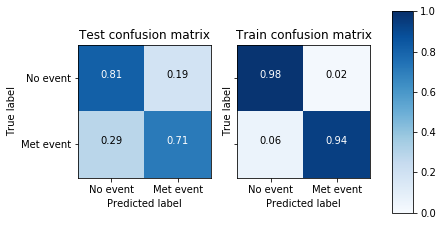

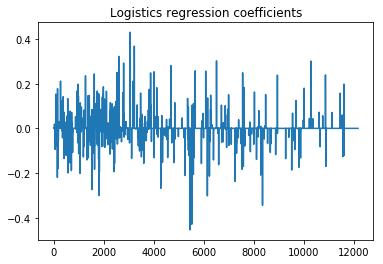

Train and test scores: 0.931129476584022 0.7489711934156379


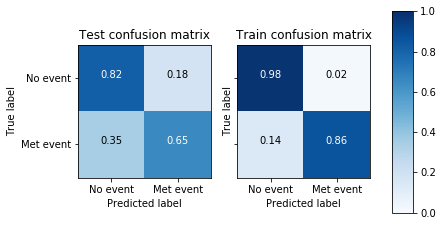

Train and test scores: 0.8457300275482094 0.6255144032921811


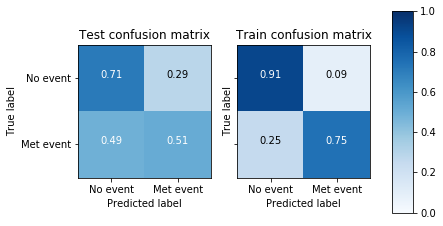

Train and test scores: 0.8774104683195593 0.6954732510288066


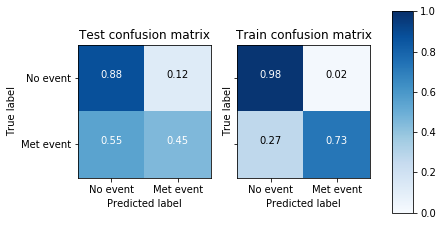

In [10]:
(clf_logit, clf_svm, clf_tree, clf_forest) = fit_models(X_train, y_train, X_test, y_test)

Train and test scores: 1.0 0.7325102880658436


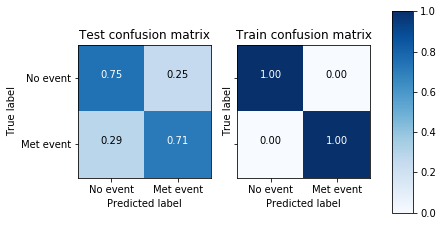

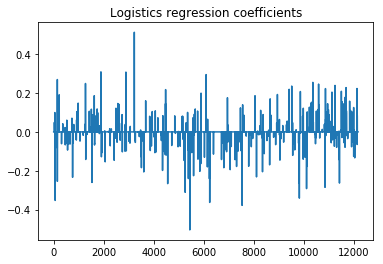

Train and test scores: 1.0 0.7448559670781894


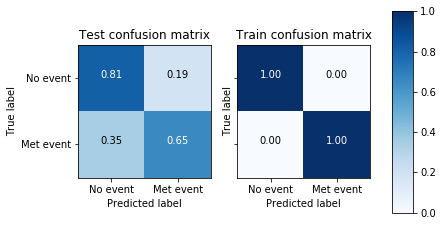

Train and test scores: 0.8457300275482094 0.6460905349794238


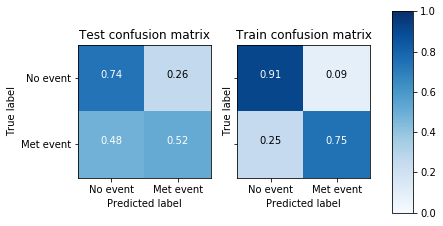

Train and test scores: 0.859504132231405 0.691358024691358


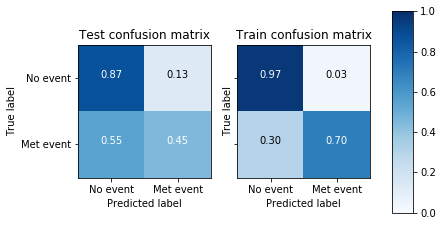

In [11]:
(clf_logit, clf_svm, clf_tree, clf_forest) = fit_models(X_std_train, y_train, X_std_test, y_test)

In [12]:
#test thresholding for loogit regression
threshold = 0.1
preds_train = np.array([1 if x > threshold else 0 for x in clf_logit.predict_proba(X_std_train)[:,1]])
preds_test = np.array([1 if x > threshold else 0 for x in clf_logit.predict_proba(X_std_test)[:,1]])
cm_train = confusion_matrix(y_train, preds_train)
cm_train = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]
cm_test = confusion_matrix(y_test, preds_test)
cm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
print(cm_train)
print(cm_test)

[[0.776 0.224]
 [0.    1.   ]]
[[0.475 0.525]
 [0.135 0.865]]


417
Train and test scores: 0.9917355371900827 0.7325102880658436


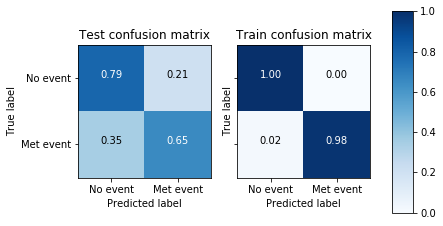

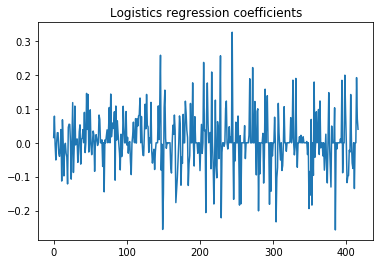

Train and test scores: 1.0 0.7325102880658436


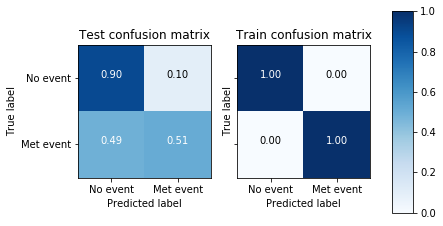

Train and test scores: 0.7796143250688705 0.6255144032921811


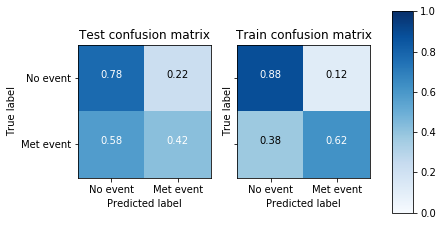

Train and test scores: 0.7823691460055097 0.5720164609053497


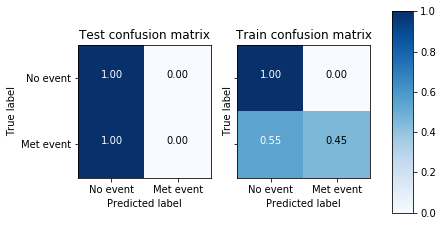

In [13]:
pca_transform = PCA(n_components=0.95, svd_solver='full').fit(X_std_train)
print(pca_transform.n_components_)
X_pca_train = pca_transform.transform(X_std_train)
X_pca_test = pca_transform.transform(X_std_test)
(clf_logit, clf_svm, clf_tree, clf_forest) = fit_models(X_pca_train, y_train, X_pca_test, y_test)

Train and test scores: 0.8760330578512396 0.5761316872427984


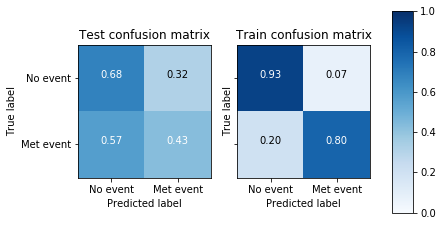

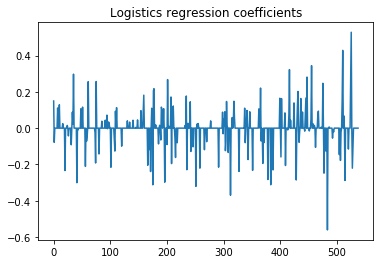

Train and test scores: 0.9986225895316805 0.7037037037037037


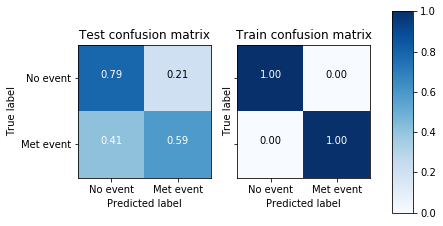

Train and test scores: 0.8181818181818182 0.654320987654321


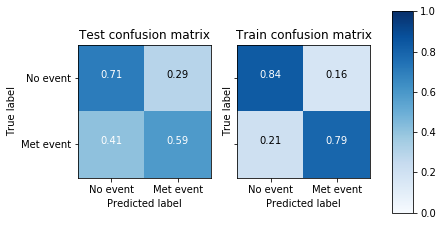

Train and test scores: 0.8443526170798898 0.6666666666666666


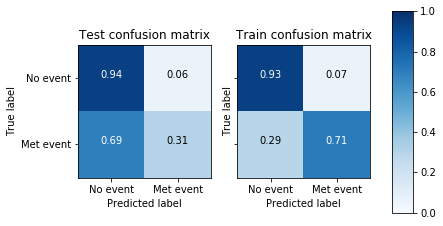

In [14]:
(clf_logit, clf_svm, clf_tree, clf_forest) = fit_models(X_mlcc_train, y_train, X_mlcc_test, y_test)